## Burger's equation: One-step Method

In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
from functools import partial
from jax.config import config;
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers5 import *
from loss import *
from utils import *


os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
config.update("jax_enable_x64", True)

In [14]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()
two_step_dict

{'optim_sgm_u': array([3.248985  , 3.86805308, 5.06207323]),
 'optim_nugget_u': array([1.e-08, 1.e-08, 1.e-08]),
 'rkhs_u': [1208805.036512218],
 'optim_sgm_P': 0.1591114015506264,
 'optim_nugget_P': 1e-14,
 'nugget_P': 1e-07,
 'rkhs_P_train': 0.0067226135505090235,
 'f_gh_tr_pred': array([-0.01327829, -0.01566222, -0.01590136, ...,  0.00173107,
         0.00169832,  0.00159723]),
 'rkhs_P_test': 0.006722613708661984}

### Cost function

In [16]:
two_step_dict.get('optim_sgm_u')

array([3.248985  , 3.86805308, 5.06207323])

Compute `Kphiphi` and its corresponding regularizing matrix `R`

In [17]:
# Create Kphiphi
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
# Create auxiliary functions per example. 
Kphiphis = [Kphiphi_Burgers_assembly( X_tr[i*N_tr:(i+1)*N_tr] , k = 'Gaussian2D', k_param = sigma_K[i]) for i in range(m)]

In [18]:
Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(m)]

Training data

In [19]:
# First column in Gamma(S_N,S_N)
X = X_tr # (N_train*m, 1)

# Second column in Gamma(S_N,S_N)
U = U_tr.T.reshape(N_tr*m,1) # (N_tr*m, 1)

# f(X_N)
f = U_t_tr.T.reshape(N_tr*m,1)

In [20]:
U.shape

(75, 1)

In [21]:
X_tr.shape

(75, 2)

Initial guess: `Z_warm`

In [22]:
# Load gradients from 2-step
U_x_tr_pred  = np.load('data/U_x_tr_pred.npy')
U_xx_tr_pred = np.load('data/U_xx_tr_pred.npy')
# Build Z_warm
Z_warm = np.hstack([U_x_tr_pred.T.reshape(N_tr*m,1), U_xx_tr_pred.T.reshape(N_tr*m,1)])
Z_warm = Z_warm.T.flatten()

In [23]:
two_step_dict['rkhs_u'] = np.zeros(m)

In [24]:
alpha_K = 1e-7 # Nugget 
Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(m)] 

ZZ = jnp.hstack((U.reshape(-1,1),Z_warm.reshape(2,m*N_tr).T))
# Compute the RKHS norm of u's of first iteration
for i in range(m):
    Z_0i = jnp.reshape(ZZ[N_tr*i:N_tr*(i+1),:].T, (N_tr*3,1))  
    c = jnp.linalg.solve(Kphiphis[i],Z_0i)
    rkhs_u_0i = jnp.reshape(jnp.dot(Z_0i.T , c),())
    two_step_dict['rkhs_u'][i] = rkhs_u_0i

Create objective function `L`

In [25]:
def L(Z, X, U, f, Kphiphis, Rs, two_step_dict, lmbd):
    """Cost function for 1-step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrices that regularizes each Kphiphi.
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function. 
    Returns:
        scalar: a cost of this solution.    
    """ 
    m = 3
    N = X.shape[0]
    # Re-shape Z into a matrix
    Z = Z.reshape(2,N_tr*m).T
    ### First term
    print(Z.shape)

    # Build S_N
    S1 = jnp.hstack([X,U])
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N) 
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P')
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma)) # Condition number of Gamma

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f).flatten()

    # First term
    L1 = jnp.dot(f.flatten() , b) / two_step_dict.get('rkhs_P_train')
    print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    alpha_K = 1e-7 # Nugget 
    #Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(m)] 
    #print("cond(Kphiphi) = ", jnp.linalg.cond(Kphiphis[0])) # Condition number

    
    ZZ = jnp.hstack([U,Z])
    for i in range(m):
        Z_i = jnp.reshape(ZZ[N_tr*i : N_tr*(i+1) , :].T,(N_tr * 3, 1)) 
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u')[i] # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        #print(two_step_dict.get('rkhs_u'))
        #print("L2_(Z_warm)_{} = ".format(i+1),jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u'))
    # Compute the total loss per epoch - It's going down !
    # Compute the loss per function u epoch  
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Training data and warm up

In [26]:
L(Z_warm, X, U, f, Kphiphis, Rs, two_step_dict, lmbd = 1/m)

(75, 2)
L1(Z_warm) =  1.0000000000000273
L2(Z_warm) =  3.0


Array(2., dtype=float64)

In [27]:
lmbd_min = 1/m 

#### LBFGS

In [28]:
# Load the warm-up 
Z = np.copy(Z_warm) 

In [29]:
Z_warm.shape

(150,)

In [39]:
solver = LBFGS(fun=L, maxiter=1000)
res = solver.run(Z, X = X, U = U, f = f, Kphiphis= Kphiphis, Rs =Rs, two_step_dict=two_step_dict, lmbd=1/m)

(75, 2)
L1(Z_warm) =  Traced<ConcreteArray(1.5214603629604488, dtype=float64)>with<JVPTrace(level=2/1)> with
  primal = Array(1.52146036, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f788c784ea0>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=1/1)>, Traced<ConcreteArray(0.0067226135505090235, dtype=float64):JaxprTrace(level=1/1)>), out_tracer_refs=[<weakref at 0x7f788c641b20; to 'JaxprTracer' at 0x7f788c641a80>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object 

In [34]:
Z = res.params.reshape(2, N_tr*m).T

In [41]:
Z.shape

(75, 2)

In [38]:
Z_warm.reshape(2, N_tr*m).T

(150,)

In [ ]:
result = minimize(L, Z, args=(X, U, f, Kphiphis, Rs, two_step_dict, 1/m), method= 'BFGS')

In [ ]:
Z = result.x.reshape(2, N_tr*m).T

#### Evaluation of `Z`

In [43]:
# Load true gradients from 2-step
U_x_tr = np.load('data/U_x_tr.npy')
U_xx_tr = np.load('data/U_xx_tr.npy')
# Build true Z
Z_true = np.hstack([U_x_tr.T.reshape(N_tr * m,1), U_xx_tr.T.reshape(N_tr*m,1)])

#### Predictions of P

Recall on the Representer formula

$$
P^*(\cdot) = \Gamma(\cdot,S_N) \Gamma(S_N,S_N)^{-1} f(X_N)
$$

In [44]:
# Build S_N - Training data
S1 = jnp.hstack([X_tr, U])
S = jnp.hstack([S1, Z])
# Load gradients from 2-step
U_x_te_pred  = np.load('data/U_x_te_pred.npy')
U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
s_test = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1), U_xx_te_pred.T.reshape(-1,1)))  # 30 * 4
f_train = U_t_tr.T.reshape(N_tr*m,1).flatten()
f_test = U_t_te.T.reshape(N_te*m,1).flatten()
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s, f_train)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_train)
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)
f_train2 = -S[:,2]*S[:,3] + 0.01*S[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]

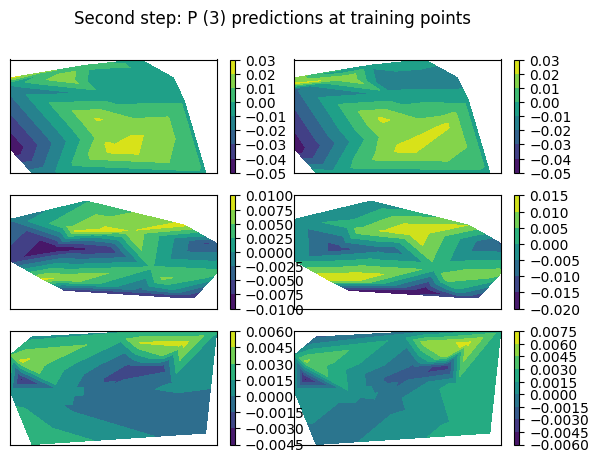

In [45]:
# Interpolant P^* at training points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(S[i*N_tr:(i+1)*N_tr,0], S[i*N_tr:(i+1)*N_tr,1], f_pred_train[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(S[i*N_tr:(i+1)*N_tr,0], S[i*N_tr:(i+1)*N_tr,1], f_train2[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

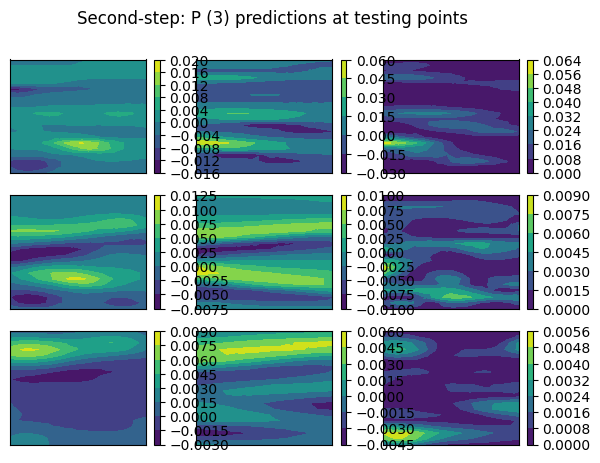

In [46]:
# Interpolant P^* at testing points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(s_test[i*N_te:(i+1)*N_te,0], s_test[i*N_te:(i+1)*N_te,1], f_pred_test[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(s_test[i*N_te:(i+1)*N_te,0], s_test[i*N_te:(i+1)*N_te,1], f_test2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_test2[i*N_te:(i+1)*N_te]-f_pred_test[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [47]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(f_train2[i*N_tr:(i+1)*N_tr], f_pred_train[i*N_tr:(i+1)*N_tr])
    n_mse_test = rel_mse(f_test2[i*N_te:(i+1)*N_te], f_pred_test[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 3 functions
m = 0 nmse_train = 0.49489922850038603
m = 0 nmse_test = 0.8781862625600712
m = 1 nmse_train = 0.548707316778507
m = 1 nmse_test = 0.5718945917110966
m = 2 nmse_train = 0.5727495902581976
m = 2 nmse_test = 0.674290073888036


In [ ]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(S, axis = 0)
    beta = np.arange(0.0,0.25,0.05)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(S)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,2] = np.random.normal(S[:,2] , scale = scale[2])
        # Apply step one to perturbed u's 
        optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)
        _, _, u_x_pred, u_xx_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
        s_test[:,3] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()